<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Biomass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Biomass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SAR Application: Biomass
### I. How to create SAR quicklook images of biomass? 

* Useful Products: Coherence; HV, HH, and HV power
* Useful Wavelengths: L
* Instructions to View: HV/HV ratios, RVI Index, Coherence, Pauli decomposition
* Qualitative Browse Products: How does the user know there is something in the image related to biomass before they develop/implement any algorithms? 
Vegetation structure

### II. How to interpret SAR images of biomass?

HV backscatter captures the volume contribution and increases with biomass. HV images show where the radar transmitted a horizontally polarized signal (H) and received back a vertically polarized signal (V). This depolarization occurs over vegetation as the radar signal experiences volume scattering off the branches, trunks, and leaves in the canopy. As a result, HV backscatter intensity is higher over vegetation and lower over smoother, less complex surfaces such as bare ground and more sparsely vegetated areas. 

L-band signal saturates at about 150 Mg/ha so it is appropriate for quantifying regeneration. In high-biomass areas, SAR can be used in conjunction with other instruments such as Lidar. 

## 2009 Station Fire, San Gabriel Mountains, California

This Jupyter Notebook explores UAVSAR data over the 2009 Station Fire in the San Gabriel Mountains in Los Angeles, California. The Station Fire burned over 160,000 acres in the Los Angeles National Forest from August to October 2009. 


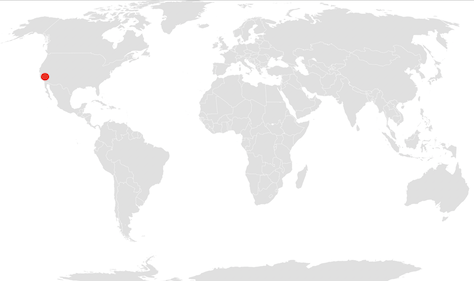

The content of this notebook is as follows:

1. [Running the Notebook](#s1)
2. [HV/HV Ratio](#s2)
3. [Radar Vegetation Index (RVI)](#s3)
4. [Multi-Temporal Composite](#s4)




<a name="s1"></a>
## 1. Running the Notebook

- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Python Packages:
This routine using the following python libaries. Some are already included in the Google Colab environment and others are first installed using pip in the cell below. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [ ]:
!pip install rasterio --quiet
!pip install geopandas --quiet
!pip install rasterstats --quiet

import rasterio as rio
#import rasterio.plot
#from rasterio.plot import show
from rasterio.plot import plotting_extent
import plotly.graph_objects as go
import rasterstats
from rasterstats import zonal_stats
from pathlib import Path

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import json

import numpy as np
import math

import ipywidgets as wg
from IPython.display import Image

     |████████████████████████████████| 19.3 MB 11.1 MB/s 
     |████████████████████████████████| 1.0 MB 3.9 MB/s 
     |████████████████████████████████| 16.7 MB 128 kB/s 
     |████████████████████████████████| 6.3 MB 35.5 MB/s 
     |████████████████████████████████| 130 kB 4.2 MB/s 


<a name="s2"></a>
## 2. UAVSAR HV/HV Ratio from 2009 Station Fire Regeneration
UAVSAR is an L-Band airborne radar and has nearly annual data acquistions of the San Gabriel Mountains since 2009. 

* UAVSAR data download page: https://uavsar.jpl.nasa.gov/cgi-bin/data.pl
* UAVSAR website: https://uavsar.jpl.nasa.gov 

Here, we look at the UAVSAR flightline SanAnd_08525, which encompasses the southern portion of the mountain range. To explore biomass changes following the 2009 station fire, we can calculate the HV/HV ratio where each acquisition post-fire is divided by the 2009 HV acquisition (i.e. HV2010/HV2009, HV2012/HV2009, etc.) Comparing the HV/HV ratio over time shows the volume ratio increasing as the vegetation recovers after the Station Fire. 

The fire perimeter is also overlaid on the UAVSAR images below to highlight the different growth patterns inside the fire scar. The National Interagency Fire Center hosts current and historic fire perimeters: https://data-nifc.opendata.arcgis.com

-----------------------------------
UAVSAR data product pages used in this exercise:

September 18, 2020: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_20026_016_200918_L090_CX_01#data

October 11, 2018: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_18076_003_181011_L090_CX_01#data

November 02, 2017: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data

October 23, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data

November 15, 2012: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_12134_001_121115_L090_CX_01#data

October 14, 2010: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_10072_005_101014_L090_CX_02#data

September 18, 2009: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_09072_002_090918_L090_CX_02#data

--------------------------------------
First, fetch UAVSAR geotiffs from the download links below with wget. Then, read in the HV geotiffs. These have been already converted to geotiff and cropped to a subset area over the moutains. 


<font color='red'> 2. Run cell below </font> 

In [ ]:
# Download data files from JPL website
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_090918_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_101014_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_121115_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_141023_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_171102_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_181011_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_200918_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_10072_007_101014_L090HHHH_CX_02.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_10072_007_101014_L090HVHV_CX_02.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_10072_007_101014_L090VVVV_CX_02.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_14158_001_141023_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_14158_001_141023_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_14158_001_141023_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_20029_004_201014_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_20029_004_201014_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_20029_004_201014_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/station_fire.geojson --quiet

<font color='red'> 3. Run cell below </font> 

In [ ]:
## Read in HV files
def read_file(path):
    with rio.open(path) as ds:
        band = ds.read(1)
    return band

HV2009 = read_file('SanAnd_08525_090918_HV.tif')
HV2010 = read_file('SanAnd_08525_101014_HV.tif')
HV2012 = read_file('SanAnd_08525_121115_HV.tif')
HV2014 = read_file('SanAnd_08525_141023_HV.tif')
HV2017 = read_file('SanAnd_08525_171102_HV.tif')
HV2018 = read_file('SanAnd_08525_181011_HV.tif')
HV2020 = read_file('SanAnd_08525_200918_HV.tif')

## Print HV files from 2009 to see array
print(HV2009)

[[0.00112577 0.00104394 0.00086048 ... 0.04626952 0.0608048  0.05941198]
 [0.00100462 0.0009929  0.00092395 ... 0.01495369 0.02256206 0.02371733]
 [0.00126803 0.00126135 0.00124184 ... 0.0023641  0.00270166 0.00246727]
 ...
 [0.05591631 0.06688657 0.07277127 ... 0.03771257 0.04064262 0.0423284 ]
 [0.06685671 0.07892905 0.08054119 ... 0.04614393 0.04279634 0.0430178 ]
 [0.05718148 0.07363004 0.07424377 ... 0.05723666 0.04511245 0.04403196]]


Next, convert the UAVSAR images from linear power to decibels (dB) before creating the HV/HV ratios. The decibel values are lower in areas of lower HV backscatter or less vegetation.  

<font color='red'> 4. Run cell below </font> 

In [ ]:
## Convert to decibels (dB)
def convert_db(data):
    db = 10*(math.log10(data))
    return db
converted_db = np.vectorize(convert_db)

HV2009 = converted_db(HV2009)
HV2010 = converted_db(HV2010)
HV2012 = converted_db(HV2012)
HV2014 = converted_db(HV2014)
HV2017 = converted_db(HV2017)
HV2018 = converted_db(HV2018)
HV2020 = converted_db(HV2020)

## Print the HV file from 2009 to see array of decibel values
print(HV2009)

[[-29.48551931 -29.81323847 -30.65260213 ... -13.3470496  -12.16062115
  -12.26126   ]
 [-29.98000097 -30.03094085 -30.34351862 ... -18.25251718 -16.4662124
  -16.24934121]
 [-28.96870781 -28.99164469 -29.05935959 ... -26.26334422 -25.68368721
  -26.07784099]
 ...
 [-12.52461501 -11.74661097 -11.38040069 ... -14.23513867 -13.91018273
  -13.73368123]
 [-11.74854985 -11.02763115 -10.93981939 ... -13.35885416 -13.68593335
  -13.66351832]
 [-12.42744627 -11.3294495  -11.29339989 ... -12.42325715 -13.45703625
  -13.56231992]]


Read in station fire perimeter shapefile and overlay onto the HV images in dB. 

<font color='red'> 5. Run cell below </font> 

In [ ]:
## Get geographic information from geotiff
with rio.open('SanAnd_08525_090918_HV.tif') as subset_src:
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform

## Read in fire shapefile perimeter
fire_boundary = gpd.read_file('station_fire.geojson')
fire_boundary = fire_boundary.to_crs(subset_src.crs)

## specify top left corner lat/lon
top_left_lon = -118.12592154
top_left_lat = 34.31671734

## Specify extent for plotting
extent_mat = (top_left_lon, top_left_lon + subset_src.shape[1] * 0.00005556000000000000337, top_left_lat - subset_src.shape[0] * 0.00005556000000000000337, top_left_lat)
extent_mat

(-118.12592154, -117.9165159, 34.20004134, 34.31671734)

Get zonal statistics within the fire perimeter area for each HV geotiff.

<font color='red'> 6. Run cell below </font> 

In [ ]:
# raster_list = ['SanAnd_08525_090918_HV.tif','SanAnd_08525_101014_HV.tif','SanAnd_08525_121115_HV.tif',
#                 'SanAnd_08525_141023_HV.tif','SanAnd_08525_171102_HV.tif','SanAnd_08525_181011_HV.tif',
#                 'SanAnd_08525_200918_HV.tif']

raster_list = [HV2009, HV2010, HV2012, HV2014, HV2017, HV2018, HV2020]
years = ['2009', '2010', '2012', '2014', '2017', '2018', '2020']

raster_stats = []
for raster in raster_list:
    result = zonal_stats("station_fire.geojson", raster, stats="min max median", affine=trans, geojson_out=True)
    # print(result)
    for f in result:
        props = f['properties']
        mean = props['median']
        max = props['max']
        min = props['min']
        all = [mean, min, max]
        # print(all)
        raster_stats.append(all)

raster_stats = pd.DataFrame(raster_stats,columns=['median','min', 'max'])
years = pd.Series(years, name="year")
pd.to_datetime(years)
raster_stats = pd.merge(years, raster_stats, right_index=True, left_index=True)
raster_stats

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,year,median,min,max
0,2009,-20.770161,-42.455266,6.900069
1,2010,-22.579100,-41.633637,0.213635
2,2012,-20.520293,-38.089443,2.195592
3,2014,-20.257143,-36.947941,1.873884
4,2017,-21.201564,-37.558931,3.795128
5,2018,-18.336651,-32.243215,5.321186
6,2020,-19.679412,-36.971764,4.989650


<font color='red'> 7. Run cell below </font> 

In [ ]:
#@title Time Series Plot
######## Plot Time series ########
## Change so the spread is based on the min/max from the standard deviation

fig = go.Figure()
# fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["burnt mean"], name="Not Burnt", 
#                          error_y="burnt max", error_y_minus="burnt min"
#     ))

fig.add_trace(go.Scatter(x=raster_stats["year"], y=raster_stats["median"], name="Median", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)
    ))


fig.update_xaxes(
    dtick="M1",
    tickformat="\n%Y")

fig.update_layout(
    title="HV values in fire scar post 2009 Station Fire. 25% error bar",
    xaxis_title="Year of UAVSAR Collection",
    yaxis_title="decibels (dB)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    )
)

fig.show()

#With matplotlib:
#plt.fill_between(range(100), mean-standard_dev, mean+standard_dev, alpha = 0.5)

Create HV/HV Ratio

<font color='red'> 8. Run cell below </font> 

In [ ]:
ratio_2009_2010 = HV2010/HV2009
ratio_2009_2012 = HV2012/HV2009
ratio_2009_2014 = HV2014/HV2009
ratio_2009_2017 = HV2017/HV2009
ratio_2009_2018 = HV2018/HV2009
ratio_2009_2020 = HV2020/HV2009

print(ratio_2009_2010)

## what would be helpful to print out to show the new decibel range?

[[0.93249297 0.92890082 0.91025073 ... 0.96643592 1.15526168 1.24115365]
 [0.91896823 0.9240003  0.9213164  ... 0.82678819 0.98514741 1.06497721]
 [0.94161249 0.94163238 0.94020515 ... 0.81447295 0.8705295  0.89272345]
 ...
 [1.27279795 1.10400032 1.03763921 ... 0.96233016 0.98971606 1.01344326]
 [1.21307909 1.12026291 1.11569686 ... 0.96093512 0.98826962 1.05103731]
 [1.10176757 1.11002044 1.17451409 ... 0.97543963 0.9880632  1.09521808]]


Plot each HV/HV ratio. The images below are scaled to 0.5 - 1.5 ratio values.

<font color='orange'> Change to HV/HV log ratio </font> 

<font color='red'> 9. Run cell below </font> 

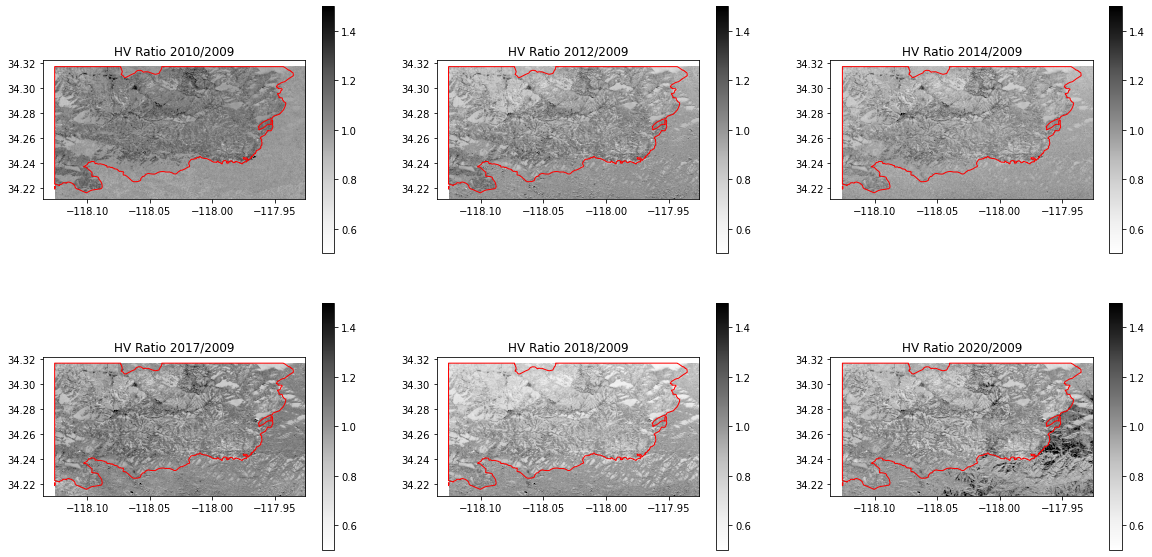

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax1)
ax1.autoscale(False)
ratio_2009_2010_plot = ax1.imshow(ratio_2009_2010, vmin=0.5, vmax=1.5, cmap="Greys", extent=extent_mat)
ax1.set_title('HV Ratio 2010/2009')
fig.colorbar(ratio_2009_2010_plot, ax=ax1)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax2)
ax2.autoscale(False)
ratio_2009_2012_plot = ax2.imshow(ratio_2009_2012, vmin=0.5, vmax=1.5, cmap="Greys", extent=extent_mat)
ax2.set_title('HV Ratio 2012/2009')
fig.colorbar(ratio_2009_2012_plot, ax=ax2)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax3)
ax3.autoscale(False)
ratio_2009_2014_plot = ax3.imshow(ratio_2009_2014, vmin=0.5, vmax=1.5, cmap="Greys", extent=extent_mat)
ax3.set_title('HV Ratio 2014/2009')
fig.colorbar(ratio_2009_2014_plot, ax=ax3)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax4)
ax4.autoscale(False)
ratio_2009_2017_plot = ax4.imshow(ratio_2009_2017, vmin=0.5, vmax=1.5, cmap="Greys", extent=extent_mat)
ax4.set_title('HV Ratio 2017/2009')
fig.colorbar(ratio_2009_2017_plot, ax=ax4)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax5)
ax5.autoscale(False)
ratio_2009_2018_plot = ax5.imshow(ratio_2009_2018, vmin=0.5, vmax=1.5, cmap="Greys", extent=extent_mat)
ax5.set_title('HV Ratio 2018/2009')
fig.colorbar(ratio_2009_2018_plot, ax=ax5)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax6)
ax6.autoscale(False)
ratio_2009_2020_plot = ax6.imshow(ratio_2009_2020, vmin=0.5, vmax=1.5, cmap="Greys", extent=extent_mat)
ax6.set_title('HV Ratio 2020/2009')
fig.colorbar(ratio_2009_2020_plot, ax=ax6)

### HV/HV Ratio Plotting
(HV acquistions 2010-2020)/(2009 HV acquisition post-fire) ratios with larger values signal that HV was lower in 2009 (or just after the fire). For example, if a burnt pixel was -25 db in 2009 and -5 db 5 years later in 2014, the ratio would be 5. We see the HV/HV ratio generally increase as the burnt area regenerates after the fire.

Darker areas in the images show lower ratio values, and brighter white areas correspond with a higher ratio value. The red area delineates the fire perimeter. 

In 2009 just after the fire, the burnt area is dark with a low ratio value and increases in brightness over time. The process is not completely linear, however. For example, the ratio values look to have generally decreased in 2017. This may be due to lower biomass from California's historic drought. In the 2009/2020 ratio, as well, can see darker values corresponding with the 2020 Bobcat Fire east of Station Fire's perimeter.

<a name="s3"></a>
## 3. Radar Vegetation Index (RVI)
The Radar Vegetation Index (RVI) is another method to leverage SAR data for forest monitoring. See this fact sheet by SERVIR for further information: https://servirglobal.net/Portals/0/Documents/Articles/2019_SAR_Handbook/SAR_Vegetation%20Indices_one-pager.pdf

We will use the formula: 8*HV/(HH+VV+2HV) to look at 2010, 2014, and 2020 UAVSAR acquistions of line SanAnd_08527 over the San Gabriel Mountains. 

----------------------------------------------

UAVSAR data product pages:

October 14, 2010: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08527_10072_007_101014_L090_CX_02#data

October 23, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08527_14158_001_141023_L090_CX_01#data

October 14, 2020: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08527_20029_004_201014_L090_CX_01#data

-------------------------------------------

First, fetch UAVSAR geotiffs from download link with wget. Then, read in subset geotiffs



<font color='red'> 10. Run cell below </font> 

In [ ]:
def read_file_zero(path):
    with rio.open(path) as ds:
        band = ds.read(1)
        #band[band > 0]
    return band

HH2010 = read_file_zero('SanAnd_08527_10072_007_101014_L090HHHH_CX_02.grd.tif')
HV2010 = read_file_zero('SanAnd_08527_10072_007_101014_L090HVHV_CX_02.grd.tif')
VV2010 = read_file_zero('SanAnd_08527_10072_007_101014_L090VVVV_CX_02.grd.tif')

HH2014 = read_file_zero('SanAnd_08527_14158_001_141023_L090HHHH_CX_01.grd.tif')
HV2014 = read_file_zero('SanAnd_08527_14158_001_141023_L090HVHV_CX_01.grd.tif')
VV2014 = read_file_zero('SanAnd_08527_14158_001_141023_L090VVVV_CX_01.grd.tif')

HH2020 = read_file_zero('SanAnd_08527_20029_004_201014_L090HHHH_CX_01.grd.tif')
HV2020 = read_file_zero('SanAnd_08527_20029_004_201014_L090HVHV_CX_01.grd.tif')
VV2020 = read_file_zero('SanAnd_08527_20029_004_201014_L090VVVV_CX_01.grd.tif')

In [ ]:
#plt.hist(VV2020.flatten(),range=[0, 0.2],bins=100)#,histtype='step')
# np.max(VV2010)

Apply RVI formula: 8*HV/(HH+VV+2HV)


<font color='red'> 11. Run cell below </font> 

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

RVI_2010 = 8*HV2010/(HH2010+VV2010+2*HV2010)
RVI_2014 = 8*HV2014/(HH2014+VV2014+2*HV2014)
RVI_2020 = 8*HV2020/(HH2020+VV2020+2*HV2020)

Plot RVI images


<font color='red'> 12. Run cell below </font> 

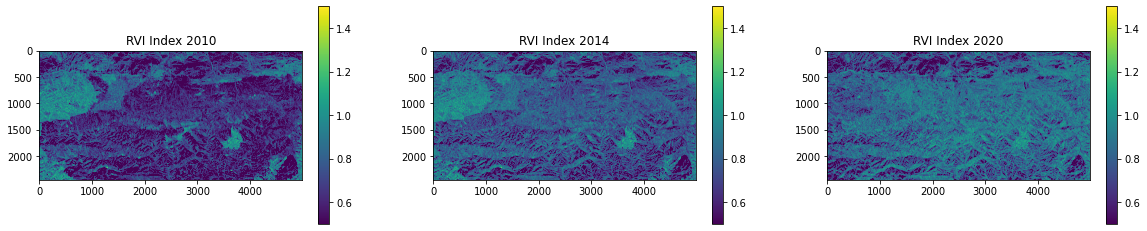

In [ ]:
### Plot 2010, 2014, 2020 RVI 
fig, ax = plt.subplots(1, 3, figsize=(20,20))
RVI_2010_plt = ax[0].imshow(RVI_2010, vmin=0.5, vmax=1.5) 
ax[0].set_title('RVI Index 2010')
fig.colorbar(RVI_2010_plt, ax=ax[0], shrink=0.2) 

RVI_2014_plt = ax[1].imshow(RVI_2014, vmin=0.5, vmax=1.5)
ax[1].set_title('RVI Index 2014')
fig.colorbar(RVI_2014_plt, ax=ax[1], shrink=0.2) 

RVI_2020_plt = ax[2].imshow(RVI_2020, vmin=0.5, vmax=1.5)
ax[2].set_title('RVI Index 2020')
fig.colorbar(RVI_2020_plt, ax=ax[2], shrink=.2) 

Plot RVI Histograms


<font color='red'> 13. Run cell below </font> 

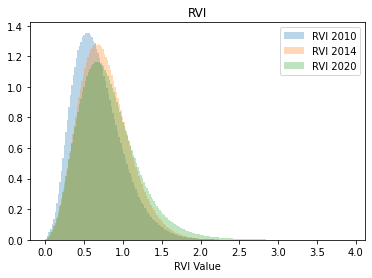

In [ ]:
### Plot histogram of full image or select areas
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=200, density=True)

plt.hist(RVI_2010.flatten(), **kwargs, label='RVI 2010')
plt.hist(RVI_2014.flatten(), **kwargs, label='RVI 2014')
plt.hist(RVI_2020.flatten(), **kwargs, label='RVI 2020');

plt.xlabel('RVI Value')
plt.ylabel('')
plt.title('RVI')
plt.legend(prop={'size': 10})


<a name="s4"></a>
## 4. Multi-Temporal Composite

This false-color RGB composite was created from 3 L-Band HV UAVSAR images over the San Gabriel Mountains, acquired on October 14th 2010, November 2nd 2017, and October 15th 2020. The composite’s resulting color is determined by each layer’s relative HV intensity and reveals which year(s) had the highest HV return. 
 


In this multi-temporal composite, HV’s sensitivity to changes in vegetation and biomass highlights the different fire extents across time. For the 2009 Station Fire, higher HV return occurred in 2017 and 2020 after the burnt area’s vegetation had time to regenerate. Thus, green (2017) and blue (2020) dominate the Station Fire’s extent. In contrast, fires that occurred between the 2010 and 2017 UAVSAR data collections  appear red – these areas had greater HV returns and denser vegetation in 2010 before the fires. The Bobcat Fire occurred just before the 2020 UAVSAR acquisition and appears yellow due to higher HV intensity and denser vegetation in 2010 and 2017 before the fire.
 

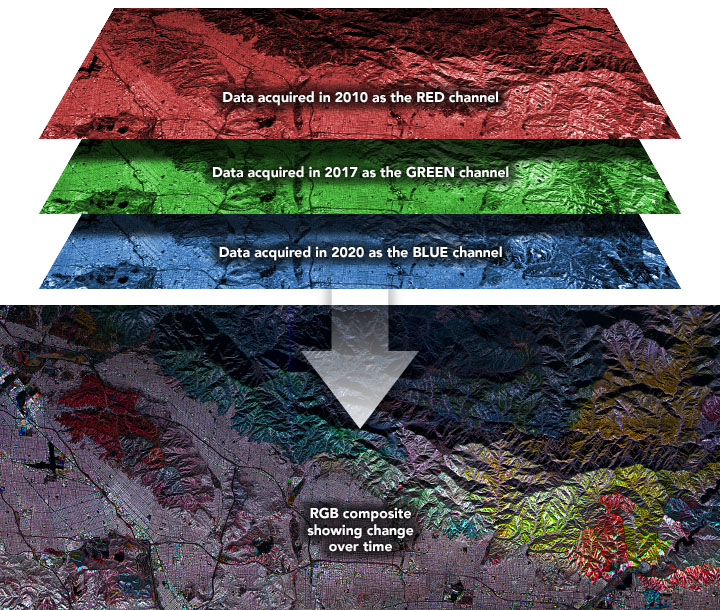

In this multi-temporal composite, HV’s sensitivity to changes in vegetation and biomass highlights the different fire extents across time. For the 2009 Station Fire, higher HV return occurred in 2017 and 2020 after the burnt area’s vegetation had time to regenerate. Thus, green (2017) and blue (2020) dominate the Station Fire’s extent. In contrast, fires that occurred between the 2010 and 2017 UAVSAR data collections  appear red – these areas had greater HV returns and denser vegetation in 2010 before the fires. The Bobcat Fire occurred just before the 2020 UAVSAR acquisition and appears yellow due to higher HV intensity and denser vegetation in 2010 and 2017 before the fire.

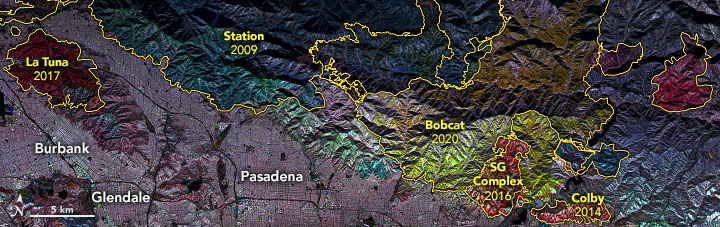

## Other Resources

UAVSAR Data Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

## References

Marshak, C., Simard, M., Duncanson, L., Silva, C.A., Denbina, M., Liao, T.-H., Fatoyinbo, L., Moussavou, G. Armston, J. (2020). Regional Tropical Aboveground Biomass Mapping with L-Band Repeat-Pass Interferometric Radar, Sparse Lidar, and Multiscale Superpixels. Remote Sensing 12, 2048. DOI: 10.3390/rs12122048. https://www.mdpi.com/2072-4292/12/12/2048/htm


SERVIR SAR Handbook: SAR Vegetation Indices. https://servirglobal.net/Portals/0/Documents/Articles/2019_SAR_Handbook/SAR_Vegetation%20Indices_one-pager.pdf

Yu, Y., & Saatchi, S. (2016). Sensitivity of L-Band SAR Backscatter to Aboveground Biomass of Global Forests. Remote Sensing, 8(6), 522. doi:10.3390/rs8060522

Earth Observatory: https://earthobservatory.nasa.gov/images/147872/a-mosaic-of-fire-data

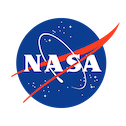

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2020. California Institute of Technology. Government sponsorship acknowledged. 